In [1]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import rl_utils

In [2]:
class PolicyNet(torch.nn.Module):
    """策略网络"""
    def __init__(self, state_dim, hidden_dim, action_dim):
        """

        :param state_dim: 状态空间维度
        :param hidden_dim: 隐藏层维度
        :param action_dim: 动作空间维度
        """
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

In [15]:
class REINFORCE:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, device):
        """
        REINFORCE
        :param state_dim: 状态空间维度
        :param hidden_dim: 隐藏层维度
        :param action_dim: 动作空间维度
        :param learning_rate: 学习率
        :param gamma: 折扣因子
        :param device:
        """
        # 构建策略网络
        self.policy_net = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        # 优化器
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=learning_rate)  # 使用Adam优化器
        self.gamma = gamma  # 折扣因子
        self.device = device

    def take_action(self, state):  # 根据动作概率分布随机采样
        # [1, state_dim]
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        # [1, action_dim] 选择动作概率
        probs = self.policy_net(state)
        # 构建动作分布
        action_dist = torch.distributions.Categorical(probs)
        # 动作采样
        action = action_dist.sample()

        return action.item()

    def update(self, transition_dict):
        reward_list = transition_dict['rewards']
        state_list = transition_dict['states']
        action_list = transition_dict['actions']

        G = 0
        self.optimizer.zero_grad()
        for i in reversed(range(len(reward_list))):  # 从最后一步算起
            reward = reward_list[i]
            # 第i-step的状态 [1, 4]
            state = torch.tensor([state_list[i]], dtype=torch.float).to(self.device)
            # 第i-step的动作 [1, 1]
            action = torch.tensor([action_list[i]]).view(-1, 1).to(self.device)
            # 计算该动作概率log
            log_prob = torch.log(self.policy_net(state).gather(1, action))
            # 第i-step下的回报
            G = self.gamma * G + reward
            loss = -log_prob * G  # 每一步的损失函数
            loss.backward()  # 反向传播计算梯度

        self.optimizer.step()  # 梯度下降

In [23]:
learning_rate = 8e-4
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = "CartPole-v1"
env = gym.make(env_name)
# env.seed(0)
torch.manual_seed(0)

# 基于环境获取基本参数
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# 构建智能体
agent = REINFORCE(state_dim, hidden_dim, action_dim, learning_rate, gamma, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):

            episode_return = 0
            transition_dict = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
            }
            # 环境初始化
            state = env.reset()[0]
            done = False

            while not done:
                # 获取动作
                # print(state[0].shape)
                action = agent.take_action(state)
                # 环境交互获取反馈
                next_state, reward, done, *_ = env.step(action)
                # [n, 4]
                transition_dict['states'].append(state)
                # [n, 2]
                transition_dict['actions'].append(action)
                # [n, 4]
                transition_dict['next_states'].append(next_state)
                # [n, 1]
                transition_dict['rewards'].append(reward)
                # [n, 1]
                transition_dict['dones'].append(done)

                state = next_state
                episode_return += reward

            return_list.append(episode_return)
            # agent更新
            agent.update(transition_dict)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

# Iteration 0: 100%|██████████| 100/100 [00:04<00:00, 23.88it/s, episode=100,
# return=55.500]
# Iteration 1: 100%|██████████| 100/100 [00:08<00:00, 10.45it/s, episode=200,
# return=75.300]
# Iteration 2: 100%|██████████| 100/100 [00:16<00:00,  4.75it/s, episode=300,
# return=178.800]
# Iteration 3: 100%|██████████| 100/100 [00:20<00:00,  4.90it/s, episode=400,
# return=164.600]
# Iteration 4: 100%|██████████| 100/100 [00:21<00:00,  4.58it/s, episode=500,
# return=156.500]
# Iteration 5: 100%|██████████| 100/100 [00:21<00:00,  4.73it/s, episode=600,
# return=187.400]
# Iteration 6: 100%|██████████| 100/100 [00:22<00:00,  4.40it/s, episode=700,
# return=194.500]
# Iteration 7: 100%|██████████| 100/100 [00:23<00:00,  4.24it/s, episode=800,
# return=200.000]
# Iteration 8: 100%|██████████| 100/100 [00:23<00:00,  4.33it/s, episode=900,
# return=200.000]
# Iteration 9: 100%|██████████| 100/100 [00:22<00:00,  4.14it/s, episode=1000,
# return=186.100]

Iteration 9: 100%|██████████| 100/100 [00:02<00:00, 38.52it/s, episode=1000, return=150.300]


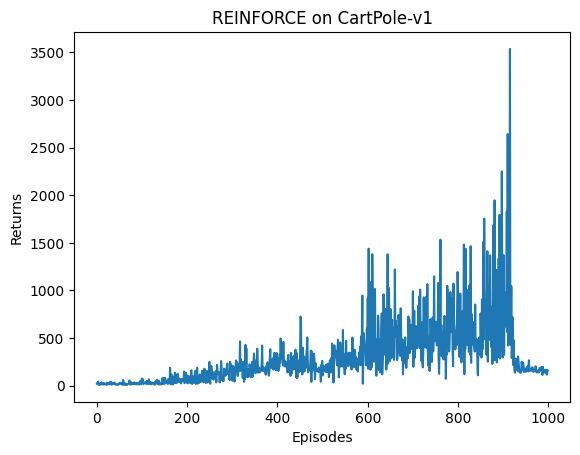

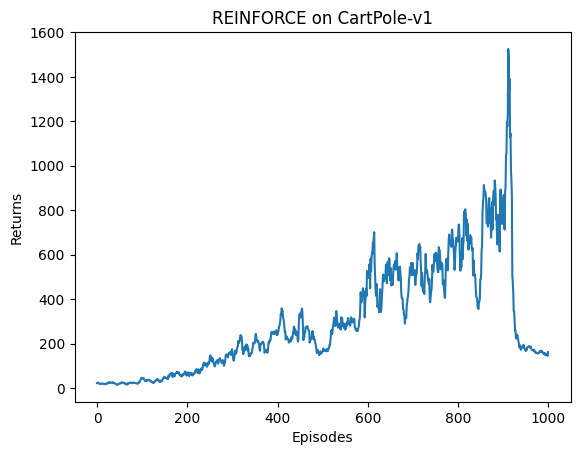

In [24]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()